In [1]:
from __future__ import print_function

import itertools as it

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import joblib

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc, metrics

In [2]:
cpu = joblib.cpu_count()

In [3]:
sample = pd.read_pickle("data/scaled/sample.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
data = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [4]:
RF_PARAMS = {
    'max_features': None, 'min_samples_split': 10, 'n_jobs': cpu, 
    'criterion': 'entropy', 'n_estimators': 500}

sX_columns = [
    'Beyond1Std',
    'Eta_e',
    'Freq1_harmonics_amplitude_0',
    'LinearTrend',
    'MaxSlope',
    'Mean',
    'Meanvariance',
    'Psi_eta',
    'Rcs',
    'c89_m2',
    'cnt',
    'n09_c3',
    'n09_hk_color',
    'n09_m2']

In [5]:
POSITIONS = {
    'b220': (12, 8),
    'b234': (11, 8),
    'b247': (10, 9),
    'b248': (10, 8),
    'b261': ( 9, 9),
    'b262': ( 9, 8),
    'b263': ( 9, 7),
    'b264': ( 9, 6),
    'b277': ( 8, 7),
    'b278': ( 8, 6),
    'b396': ( 0, 0),
}

order = sorted(POSITIONS, key=POSITIONS.get, reverse=True)

combs = {}
for ta, tb in it.combinations(order, 2):
    k = "{}_{}".format(ta, tb)
    df = pd.concat([data[ta], data[tb]])
    
    cls = {name: idx for idx, name in enumerate(df.tile.unique())}
    df["cls"] = df.tile.apply(cls.get)
    
    combs[k] = df

data = Container(combs)
del combs

cls = {0: 0, 1: 1}

In [6]:
%%time
results = {}
total = len(data.keys())
for idx, c in enumerate(data.keys()):
    print("[{}/{}] {} vs {}".format(idx, total, *c.split("_")))
    rf = KFoldExperiment(
        clf=RandomForestClassifier(**RF_PARAMS), clsnum=cls, verbose=False,
        data=data, pcls=1, ncls=0, X_columns=sX_columns, y_column="cls")
    rf = rf(c, nfolds=10)
    results[c] = rf

[0/55] b247 vs b396
[1/55] b264 vs b396
[2/55] b263 vs b277
[3/55] b263 vs b278
[4/55] b248 vs b261
[5/55] b248 vs b262
[6/55] b248 vs b263
[7/55] b248 vs b264
[8/55] b220 vs b234
[9/55] b264 vs b277
[10/55] b234 vs b277
[11/55] b220 vs b396
[12/55] b247 vs b263
[13/55] b247 vs b262
[14/55] b234 vs b278
[15/55] b264 vs b278
[16/55] b277 vs b278
[17/55] b220 vs b277
[18/55] b262 vs b277
[19/55] b247 vs b248
[20/55] b247 vs b261
[21/55] b220 vs b278
[22/55] b261 vs b263
[23/55] b261 vs b262
[24/55] b277 vs b396
[25/55] b234 vs b396
[26/55] b248 vs b278
[27/55] b247 vs b277
[28/55] b261 vs b396
[29/55] b263 vs b264
[30/55] b220 vs b263
[31/55] b234 vs b263
[32/55] b234 vs b262
[33/55] b234 vs b261
[34/55] b220 vs b248
[35/55] b234 vs b248
[36/55] b234 vs b264
[37/55] b262 vs b264
[38/55] b234 vs b247
[39/55] b220 vs b247
[40/55] b261 vs b264
[41/55] b262 vs b263
[42/55] b248 vs b277
[43/55] b220 vs b264
[44/55] b220 vs b262
[45/55] b263 vs b396
[46/55] b261 vs b278
[47/55] b220 vs b261
[4

In [12]:
rows = []
for k, r in sorted(results.items()):
    ta, tb = k.split("_")
    row = {
        "Tile A": ta, 
        "Tile B": tb,
        "Prec.": metrics.precision_score(r.y_test, r.predictions),
        "Recall": metrics.recall_score(r.y_test, r.predictions),
        "AUC": r.roc_auc}
    rows.append(row)

In [8]:
df = pd.DataFrame(rows)[["Tile A", "Tile B", "Prec.", "Recall", "AUC"]]
df.head()

,Tile A,Tile B,Prec.,Recall,AUC
0,b220,b234,0.901283,0.913000,0.969707
1,b220,b247,0.913776,0.922000,0.974619
2,b220,b248,0.888889,0.897796,0.963623
3,b220,b261,0.873518,0.885772,0.946605
4,b220,b262,0.873621,0.874498,0.945917


In [9]:
df.describe()

,Prec.,Recall,AUC
count,55.000000,55.000000,55.000000
mean,0.865416,0.874939,0.939144
std,0.075678,0.077037,0.073102
min,0.566038,0.570000,0.592847
25%,0.850810,0.873749,0.945630
50%,0.888889,0.893000,0.963822
75%,0.911080,0.916081,0.971507
max,0.934322,0.951807,0.984015


In [10]:
df.to_pickle("data/results/all_vs_all.pkl")

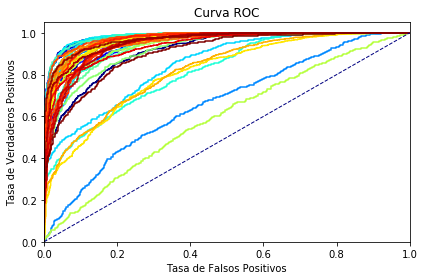

In [11]:
from matplotlib import cm

def roc(results, cmap="jet", ax=None, save_to=None):
    if ax == None:
        ax = plt.gca()
    
    cmap = cm.get_cmap(cmap)
    colors = iter(cmap(np.linspace(0, 1, len(results))))

    if isinstance(results, dict):
        for cname, res  in results.items():
            color = next(colors)
            label = '%s (area = %0.2f)' % (cname, res["roc_auc"])
            ax.plot(res["fpr"], res["tpr"], color=color, label=label)
    else:
        for res in results:
            cname = "Vs.{}".format(res.test_name)
            color = next(colors)
            label = '%s (area = %0.2f)' % (cname, res["roc_auc"])
            ax.plot(res["fpr"], res["tpr"], color=color, label=label)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos')
    ax.set_ylabel('Tasa de Verdaderos Positivos')
    ax.set_title('Curva ROC')
#     ax.legend(loc="lower right")
    
    plt.tight_layout()
    
    return ax

roc(results)